# Lesson 5a: GPU programming in Python

## Python tools for CUDA

<br>

You've learned about CUDA in a C++ context and all about the hardware.

However, Python is the world's most popular glue-language, connecting most of the tools you need in a common environment, including CUDA and C++.

<br>

Can we do CUDA programming in Python?

<img src="../img/PyCUDA-documentation.png" width="100%">
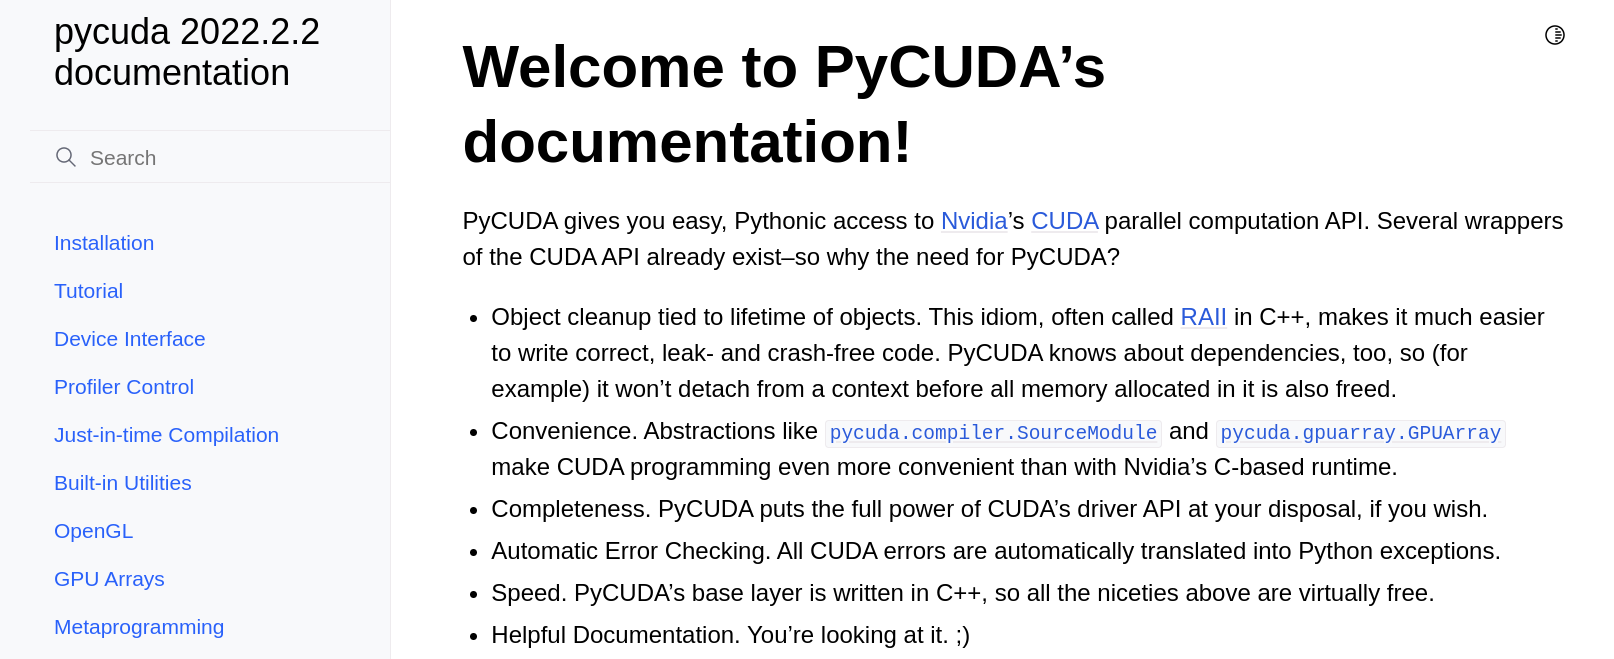

<br>

PyCUDA is one of the oldest (2008).

It has (or had?) 100% coverage of the CUDA API—anything you can do in CUDA C++ you can do in PyCUDA.


In [ ]:
import numpy as np
import pycuda.autoinit
import pycuda.compiler
import pycuda.driver as drv

module = pycuda.compiler.SourceModule(r'''
__global__ void increment(int* data) {
    data[threadIdx.x]++;
}
''')
pycuda_increment = module.get_function("increment")

<br>

In [ ]:
data = np.arange(1024, dtype=np.int32)
data

<br>

In [ ]:
pycuda_increment(drv.InOut(data), block=(1024, 1, 1))

<br>

In [ ]:
data

PyCUDA is just a wrapper around C++ CUDA: kernels in C++ as Python strings.

<br><br><br>

Its value is that we can use C++ CUDA and all your favorite Python packages in the same script.

Notice, though, that CUDA kernels are designed to operate on arrays. GPUs are naturally array-oriented, like NumPy.

<br>

Is there a version of NumPy implemented in CUDA?

<br>

In [ ]:
import cupy as cp

array = cp.arange(1, 13)
array

<br>

In [ ]:
array**2

What this looks like to CUDA (in the `nsys-ui` profiler):

In [ ]:
array = cp.random.uniform(5, 10, 100000000)
array.sort()
array

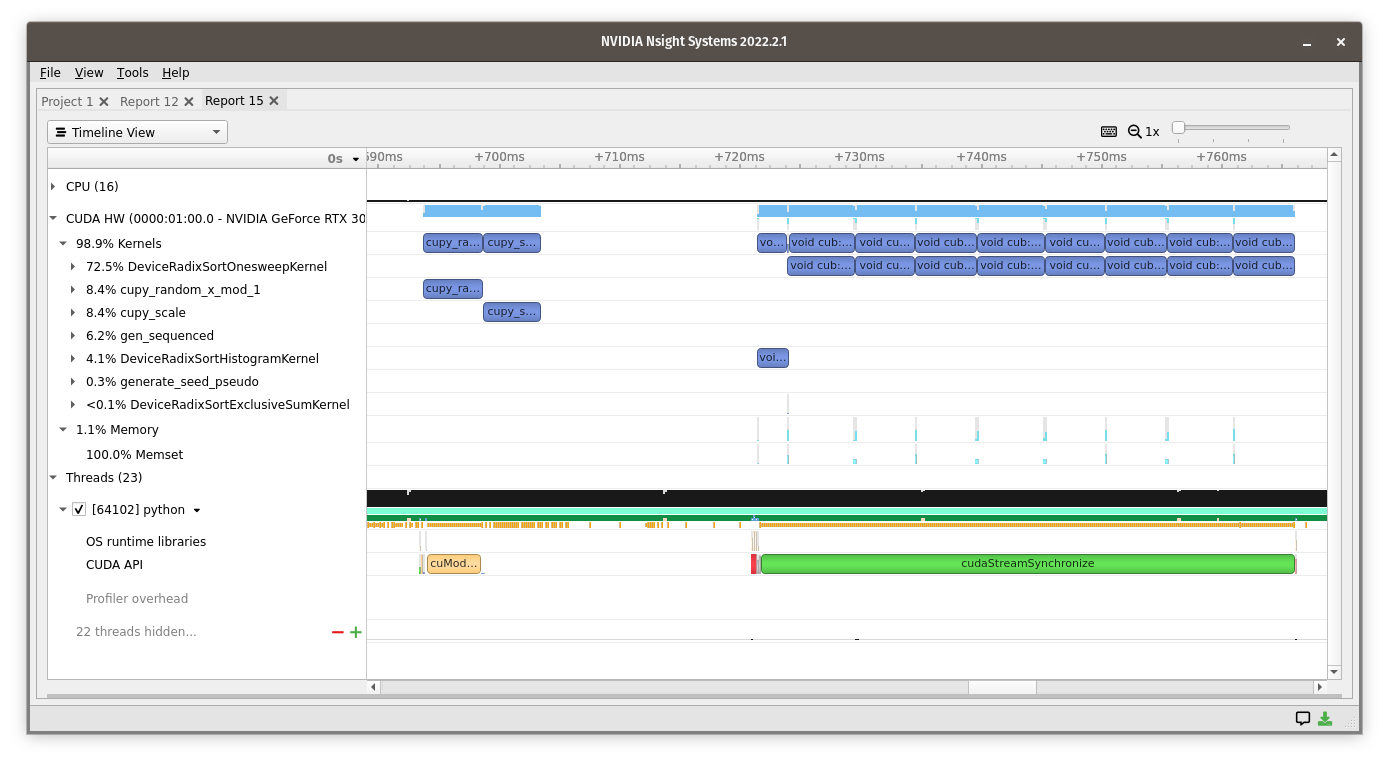

From a low-level CUDA perspective, CuPy does some surprising things:

* It allocates its own memory pools, so a new `cp.ndarray` does not mean a new `cudaMalloc`. (You can [control it](https://docs.cupy.dev/en/stable/user_guide/memory.html), but that's the default.)

* For performance reasons, it doesn't _perfectly_ reproduce the NumPy API. It's not _exactly_ a drop-in replacement, but it's close. ("Drop-in and fix-up.")

* Some things that would be errors in NumPy have definitions in CuPy:

<br>

In [ ]:
array = cp.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5])
array[cp.array([2, 3, 5])]

<br>

In [ ]:
array[cp.array([2, 3, 5, 6, 7, 8])]

Remember that in NumPy, an expression like

In [ ]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

<br>

is 9 passes over the data:

In [ ]:
tmp1 = np.negative(b)            # -b
tmp2 = np.square(b)              # b**2
tmp3 = np.multiply(4, a)         # 4*a
tmp4 = np.multiply(tmp3, c)      # tmp3*c
del tmp3
tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
del tmp2, tmp4
tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
del tmp5
tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
del tmp1, tmp6
tmp8 = np.multiply(2, a)         # 2*a
np.divide(tmp7, tmp8)            # tmp7 / tmp8

This is also true in CuPy. Each function is a CUDA kernel and they run one after another.

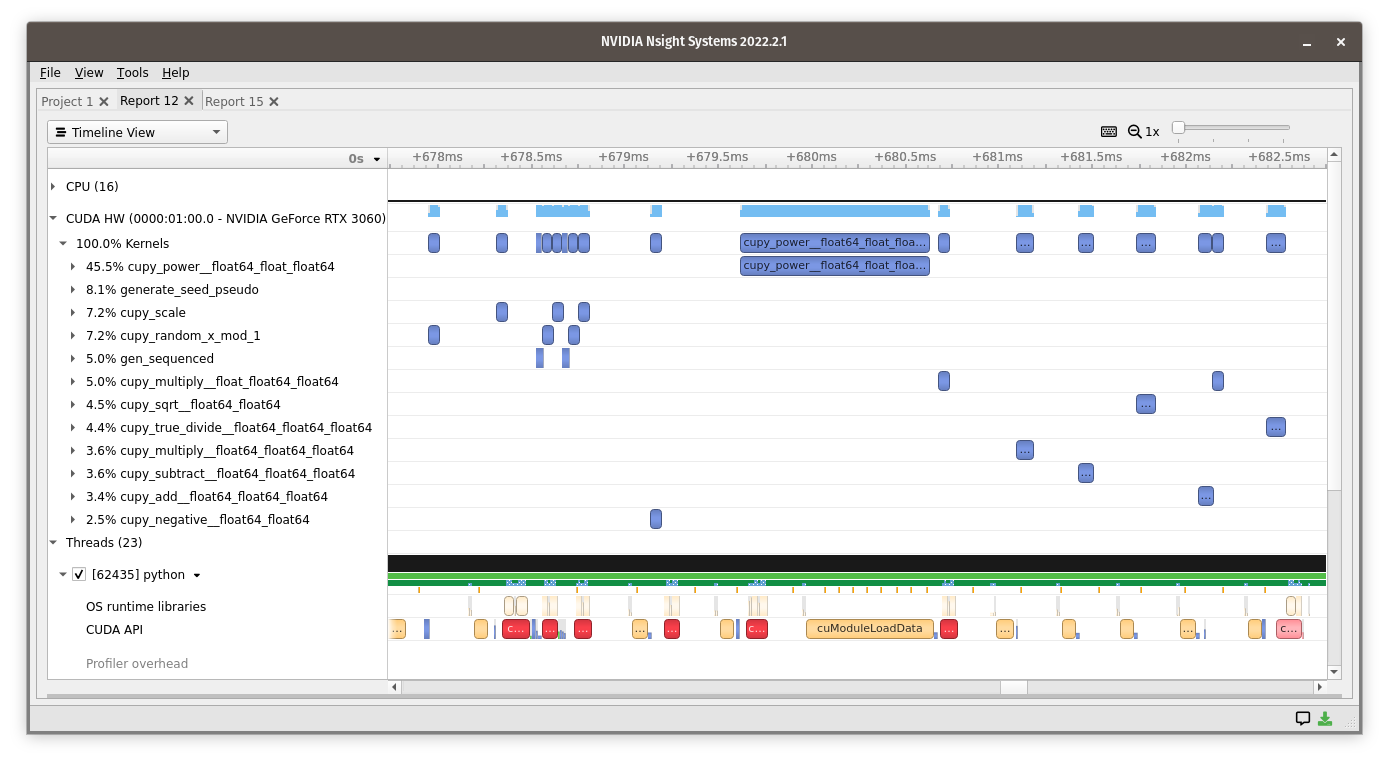

(Doing this on a GPU is not as bad as on a CPU because GPU memory is much closer to processing, but it's still an issue.)

CuPy lets you fuse operations by [JIT-compiling them](https://docs.cupy.dev/en/stable/user_guide/kernel.html). Let's compile a better alternative to `cp.pow(·, 2)`.

<br>

In [ ]:
intpow = cp.ElementwiseKernel("float64 x, int64 n", "float64 out", '''
    out = 1.0;
    for (int i = 0;  i < n;  i++) {
        out *= x;
    }
''', "intpow")
intpow

<br>

In [ ]:
a = cp.random.uniform(5, 10, 1000000)
b = cp.random.uniform(10, 20, 1000000)
c = cp.random.uniform(-0.1, 0.1, 1000000)

intpow(b, 2)

<br>

In [ ]:
b**2

But we're back to compiling C++ in strings!

```json{  "CUDA C keywords for function declaration": {    "header": ["Qualifier Keyword", "Callable From", "Executed On", "Executed By"],    "data": [      ["__host__ (default)", "Host", "Host", "Caller host thread"],      ["__global__", "Host (or Device)", "Device", "New grid of device threads"],      ["__device__", "Device", "Device", "Caller device thread"]    ]  }}```

In [ ]:
quadratic_formula_kernel = cp.RawKernel(r'''
extern "C" __global__ void
quadratic_formula(const double* a, const double* b, const double* c, double* out) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    out[i] = (-b[i] + sqrt(b[i]*b[i] - 4*a[i]*c[i])) / (2*a[i]);
}
''', "quadratic_formula")

out = cp.empty_like(a)

num_threads = 1024
num_blocks = int(np.ceil(len(out) / 1024))

quadratic_formula_kernel((num_blocks,), (num_threads,), (a, b, c, out))

out

Thus, CuPy does two things:

* supercedes PyCUDA because you can JIT-compile C++ CUDA kernels
* provides a NumPy-like array abstraction that most Python-GPU libraries recognize

However, it's not the only one.

We live in confusing times right now because most machine learning libraries define their own CUDA-capable NumPy-like arrays (and call them "tensors").

<br>

In [ ]:
import torch

a = (torch.rand(1000000)*5 + 5).to("cuda")
b = (torch.rand(1000000)*10 + 10).to("cuda")
c = (torch.rand(1000000)*0.2 - 0.1).to("cuda")

(-b + torch.sqrt(b**2 - 4*a*c)) / (2*a)

<br>

There is ongoing effort to bring these all into a single standard: https://data-apis.org/

## Compiling _Python code_ to run on GPUs

<br>

Although being able to compile C++ from Python strings gives us access to all of the C++ CUDA tools—intrinsics, libraries like CUB and Thrust, etc.—there are reasons to compile _Python code_ to run on GPUs.

* You can use the same Python types in and out of the GPU code.
* You can test parts of your algorithm—slowly—in pure Python during development.

Remember that Numba can JIT-compile Python code into CPU instructions.

<br>

In [ ]:
import numba as nb

@nb.njit
def quadratic_formula_numba(a, b, c):
    out = np.empty_like(a)
    for i in range(len(out)):
        out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])
    return out

<br>

In [ ]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

quadratic_formula_numba(a, b, c)

And Numba can also compile Python as CUDA functions ([through LLVM → NNVM → PTX](https://medium.com/rapids-ai/the-life-of-a-numba-kernel-a-compilation-pipeline-taking-user-defined-functions-in-python-to-cuda-71cc39b77625)).

<br>

In [ ]:
import numba.cuda  # must be explicitly imported
import math        # Numba-CUDA requires math.* instead of np.*

@nb.cuda.jit
def quadratic_formula_numba_cuda(a, b, c, out):
    i = nb.cuda.grid(1)   # 1-dimensional
    if i < len(out):
        out[i] = (-b[i] + math.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])

a = cp.random.uniform(5, 10, 1000000)
b = cp.random.uniform(10, 20, 1000000)
c = cp.random.uniform(-0.1, 0.1, 1000000)

out = cp.empty_like(a)

num_threads = 1024
num_blocks = int(np.ceil(len(out) / 1024))

quadratic_formula_numba_cuda[num_blocks, num_threads](a, b, c, out)

out

Here's `quadratic_formula_numba_cuda` in the profiler (running after CuPy).

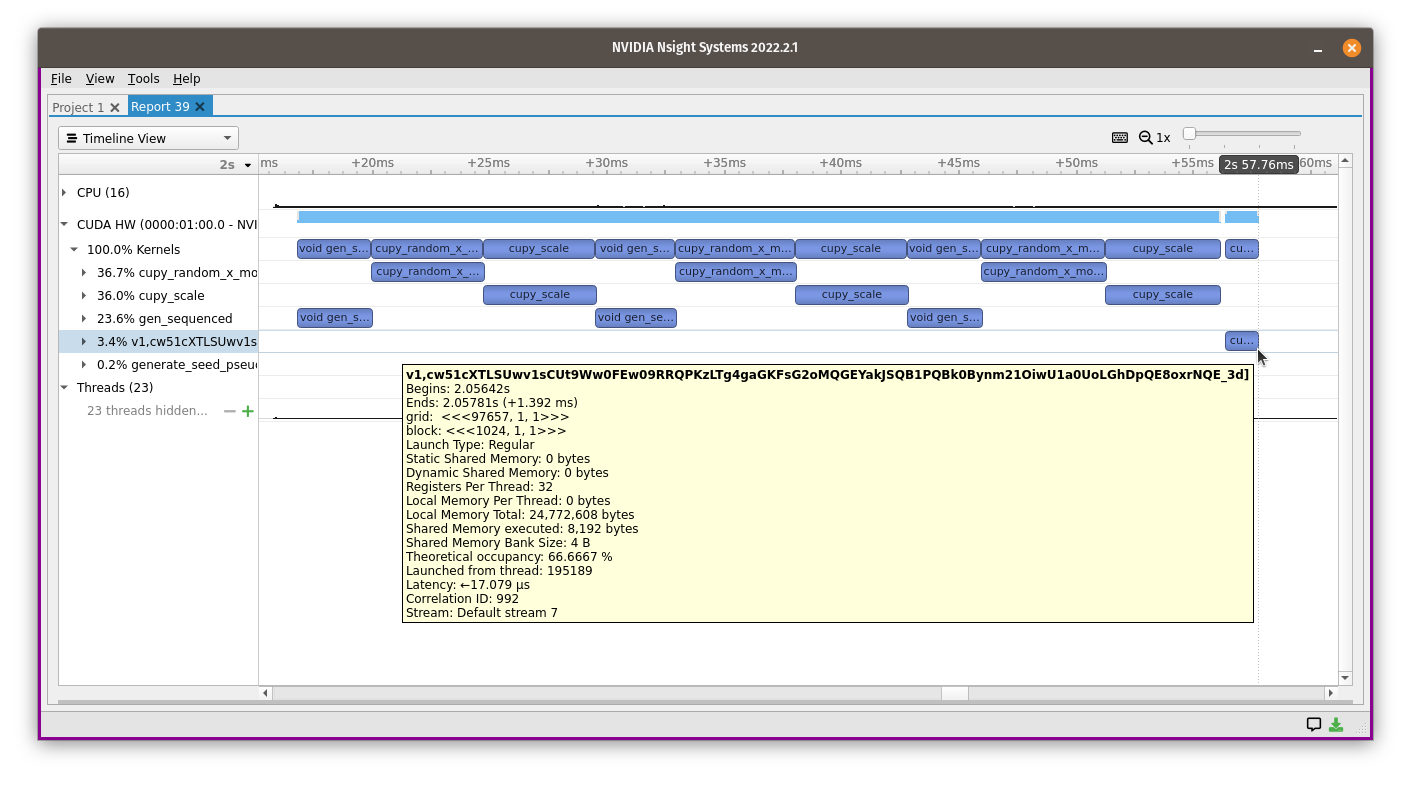

Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel

* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU

In [lesson-4-scaling/project-1-mandelbrot.ipynb](../lesson-4-scaling/project-1-mandelbrot.ipynb), some of you JIT-compiled a calculation of the Mandelbrot set with JAX.

If a GPU is available, JAX uses it (automatically fusing the array-oriented operations).

<br>

[Mandelbrot on all accelerators](https://drive.google.com/file/d/1J0l5e0NZm5kEm5BEUDG4neN5EN0VVCnt/view?usp=sharing) demonstrates the same calculation on a variety of accelerators. The bottom line:

<img src="../img/plot-mandelbrot-on-all-accelerators.svg" width="100%">

Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel
* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU

* The RAPIDS project provides higher-level tools, like the CuDF DataFrame

In [ ]:
import cudf

df = cudf.DataFrame({
    "jetid": cp.cumsum(cp.random.poisson(0.1, 1000000)),
    "px": cp.random.normal(0, 10, 1000000),
    "py": cp.random.normal(0, 10, 1000000),
    "pz": cp.random.normal(0, 10, 1000000),
    "E": cp.random.normal(20, 10, 1000000),
})
df

In [ ]:
df.groupby("jetid").sum().sort_index()

Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel
* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU
* The RAPIDS project provides higher-level tools, like the CuDF DataFrame

* Awkward Arrays can be passed as arguments to Numba, even in CUDA mode

In [ ]:
import awkward as ak

array = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
array

<br>

In [ ]:
array_cuda = ak.to_backend(array, "cuda")

<br>

In [ ]:
type(array_cuda.layout.content.data)

In [ ]:
array_cuda

<br>

In [ ]:
ak.numba.register_and_check()

@nb.cuda.jit(extensions=[ak.numba.cuda])
def sum_in_cuda(array, out):
    thread_idx = nb.cuda.grid(1)
    out[thread_idx] = 0
    for x in array[thread_idx]:
        out[thread_idx] += x

out = cp.empty(3, dtype=np.float64)

sum_in_cuda[1, 3](array_cuda, out)

<br>

In [ ]:
out

**Note:** as of this writing, Awkward Arrays can be copied to and from GPUs, but most operations have not been implemented.

<br>

In [ ]:
try:
    ak.sum(array_cuda, axis=1)
except:
    print("nope")

<br>

But passing Awkward Arrays into `@nb.cuda.jit`-compiled functions is _entirely_ implemented.

That's all we're going to use in this tutorial.

(The `ak.*` functions should be ready-for-GPU by mid-2024.)

## Computing dimuon mass on a GPU with Awkward Arrays

<br>

In [ ]:
import uproot

with uproot.open("../data/SMHiggsToZZTo4L.root:Events") as tree:
    events_pt, events_eta, events_phi, events_charge = tree.arrays(
        ["Electron_pt", "Electron_eta", "Electron_phi", "Electron_charge"], how=tuple
    )

<br>

In [ ]:
events = ak.to_backend(ak.zip({
    "pt": events_pt,
    "eta": events_eta,
    "phi": events_phi,
    "charge": events_charge,
}), "cuda")
events

First, let's just write a kernel that iterates over these events, to be sure that we can do that.

It's a good idea to develop CUDA workflows in small steps (_hint_ for the projects!).

<br>

In [ ]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def iterate_over_events(events, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        out[thread_idx] = len(events[thread_idx])

num_threads = 1024
num_blocks = int(np.ceil(len(events) / 1024))

out = cp.full(len(events), -1, dtype=np.int32)
iterate_over_events[num_blocks, num_threads](events, out)

out

<br>

In [ ]:
ak.num(events)   # one of the few functions that works in Awkward-CUDA, outside Numba

Now that we have that, let's iterate through the (variable number of) muons per event.

<br>

In [ ]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def iterate_over_electrons(events, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        for electron in events[thread_idx]:   # for muon in THIS event
            out[thread_idx] += electron.pt    # add up the scalar pT

# same num_threads, num_blocks

out = cp.zeros(len(events), dtype=np.float32)
iterate_over_electrons[num_blocks, num_threads](events, out)

out

We want to iterate over distinct pairs of electrons `e1` and `e2`, calculating the invariant mass

$$\sqrt{2\,{p_T}_1\,{p_T}_2\left(\cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2)\right)}$$

for each pair.

Let's do it in Python for a few events, first. That way, we can figure out the algorithm independently of figuring out the CUDA technicalities.

<br>

In [ ]:
for event in events[:10]:
    print(f"event with {len(event)} electrons")
    for i, e1 in enumerate(event):
        for e2 in event[i + 1:]:
            if e1.charge != e2.charge:
                print(
                    math.sqrt(
                        2*e1.pt*e2.pt * (math.cosh(e1.eta - e2.eta) - math.cos(e1.phi - e2.phi))
                    )
                )

Now take that into CUDA.

<br>

In [ ]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def mass_of_first_dielectron(events, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        event = events[thread_idx]
        for i, e1 in enumerate(event):
            for e2 in event[i + 1:]:
                if e1.charge != e2.charge:
                    out[thread_idx] = math.sqrt(
                        2*e1.pt*e2.pt * (math.cosh(e1.eta - e2.eta) - math.cos(e1.phi - e2.phi))
                    )
                    return

# same num_threads, num_blocks

out = cp.zeros(len(events), dtype=np.float32)
mass_of_first_dielectron[num_blocks, num_threads](events, out)

out

This would be more legible as a `__device__` function.
In CUDA programming, a `__device__` function is a function that runs on the GPU device and can be called from other device functions or from kernel functions. These functions are executed entirely on the GPU and cannot be called from the host CPU.

A `__device__` function can return a value. It behaves similarly to regular C functions in this regard. When called, the function executes its code on the GPU and returns a result, which can then be used in other GPU functions or kernels.


<br>

In [ ]:
@nb.cuda.jit(extensions=[ak.numba.cuda], device=True)
def compute_mass(event):
    for i, e1 in enumerate(event):
        for e2 in event[i + 1:]:
            if e1.charge != e2.charge:
                return math.sqrt(
                    2*e1.pt*e2.pt * (math.cosh(e1.eta - e2.eta) - math.cos(e1.phi - e2.phi))
                )
    return -1

@nb.cuda.jit(extensions=[ak.numba.cuda])
def mass_of_first_dielectron(events, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        out[thread_idx] = compute_mass(events[thread_idx])

# same num_threads, num_blocks

out = cp.full(len(events), -1, dtype=np.float32)
mass_of_first_dielectron[num_blocks, num_threads](events, out)

out

Are these values correct? To histogram them, we need to copy the data from GPU to main memory.

<br>

In [ ]:
results = out.get()
type(results)

<br>

In [ ]:
from hist import Hist

Hist.new.Reg(120, 0, 120, label="mass").Double().fill(out.get())

## Reducing on the GPU

<br>

In your first project today, you'll be histogramming dielectron masses on the GPU itself, instead of copying the data back to main memory for histogramming.

This is a _reduction_.

<img src="../img/transformation_vs_reduction.png" width="100%">

Before getting too deep, note that these operations are built into most CUDA libraries:

<br>

In [ ]:
array = cp.random.normal(0, 1, 1024**2)
array

<br>

In [ ]:
array.sum()

<br>

(Above is a difference between NumPy and CuPy: the CuPy result is a zero-dimensional array, rather than a scalar, so that the value remains on the GPU for further calculations.)

To add all the elements of a collection with a CPU, we would ordinarily write a loop like this:

```python
result = 0
for x in collection:
    result += x
```

The naive equivalent of this on a GPU is:

In [ ]:
@nb.cuda.jit
def naive_sum(array, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(array):
        out[0] += array[thread_idx]

num_threads = 1024
num_blocks = int(np.ceil(len(array) / 1024))

out = cp.zeros(1, dtype=np.float64)
naive_sum[num_blocks, num_threads](array, out)

out

<br>

But that is not the right answer.

Here's what happened:

In [ ]:
memory = [0]

class Thread:
    def step1(self):
        self.register = memory[0]
    def step2(self):
        self.register += 1
    def step3(self):
        memory[0] = self.register
    
threadA = Thread()
threadB = Thread()

# good increment
threadA.step1(); threadA.step2(); threadA.step3()
threadB.step1(); threadB.step2(); threadB.step3()
memory

<br>

In [ ]:
# bad increment
threadA.step1(); threadB.step1()
threadA.step2(); threadB.step2()
threadA.step3(); threadB.step3()
memory

One solution to this is to prevent `threadA` and `threadB` from interleaving their steps.

Instead of using `+=` to add to `out[0]`, use an atomic operation.

<br>

In [ ]:
@nb.cuda.jit
def atomic_sum(array, out):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(array):
        nb.cuda.atomic.add(out, 0, array[thread_idx])

# same num_threads, num_blocks

out = cp.zeros(1, dtype=np.float64)
atomic_sum[num_blocks, num_threads](array, out)

out

<br>

This is correct, but all of the threads are trying to write to the same memory address at the same time. All but one of them must wait—we're losing parallelism.

Another way to do it is to avoid having any two threads write to the same array index.

We can do that by adding pairs in $\log n$ steps ($n$ is the length of the array).

<br>

<center>
    <img src="../img/tree_reduction.png" width="75%">
</center>

<center>
    <img src="../img/tree_reduction.png" width="40%">
</center>

In [ ]:
data = np.array([3, 1, 7, 0, 4, 1, 6, 3])
data

<br>

In [ ]:
data = data[::2] + data[1::2]
data

<br>

In [ ]:
data = data[::2] + data[1::2]
data

<br>

In [ ]:
data = data[::2] + data[1::2]
data

Here's the catch: each step has to wait until the previous step is entirely finished.

In [ ]:
@nb.cuda.jit
def tree_sum_step(array, n):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < n:
        array[thread_idx] += array[thread_idx + n]

# same num_threads, num_blocks

copy_of_array = array.copy()
n = len(copy_of_array)
while n >= 2:
    n = n // 2
    tree_sum_step[num_blocks, num_threads](copy_of_array, n)

copy_of_array[0]

<br>

The above works, but it could be faster if we took advantage of [shared memory and block-level synchronization](https://numba.pydata.org/numba-doc/latest/cuda/memory.html#shared-memory-and-thread-synchronization), or even [warp shuffling](https://numba.readthedocs.io/en/stable/cuda-reference/kernel.html#warp-intrinsics), which are accessible in Numba-CUDA.

But that would be too complicated to fit on one slide.